<a href="https://colab.research.google.com/github/aCStandke/GAN_Models/blob/main/Pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display

# Loading CityScape Dataset from Berkely Server:

In [3]:
dataset_name = "cityscapes"

In [4]:
_URL = f"http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz"

In [5]:
path_to_zip = tf.keras.utils.get_file(fname=f"{dataset_name}.tar.gz", 
                                      origin = _URL, 
                                      extract = True)
path_to_zip = pathlib.Path(path_to_zip)
PATH = path_to_zip.parent/dataset_name

103456768/103441232 [==============================] - 234s 2us/step


In [6]:
list(PATH.parent.iterdir())

[PosixPath('/root/.keras/datasets/cityscapes.tar.gz'),
 PosixPath('/root/.keras/datasets/cityscapes')]

In [7]:
sample_image = tf.io.read_file(str(PATH/"train/1.jpg"))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


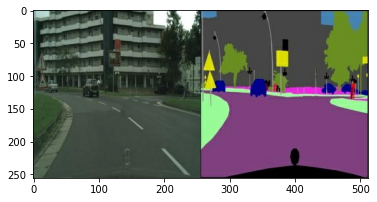

In [8]:
plt.figure()
plt.imshow(sample_image)

# Preprocessing:

In [9]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)
  width = tf.shape(image)[1] # get width of image
  width = width//2 # set width to 256
  semantic_seg_image = image[:, width:, :]
  driving_image = image[:, :width, :]
  
  driving_image = tf.cast(driving_image, tf.float16) # casting to float16 tensors
  semantic_seg_image = tf.cast(semantic_seg_image, tf.float16)

  return semantic_seg_image, driving_image

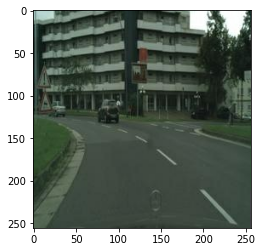

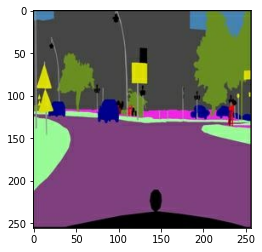

In [10]:
# inp=photo re=segmentation
re, inp = load(str(PATH/"train/1.jpg"))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(tf.cast(inp, tf.int16))
plt.figure()
plt.imshow(tf.cast(re, tf.int16))

In [11]:
BUFFER_SIZE = 2975
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [12]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [13]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [14]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [15]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

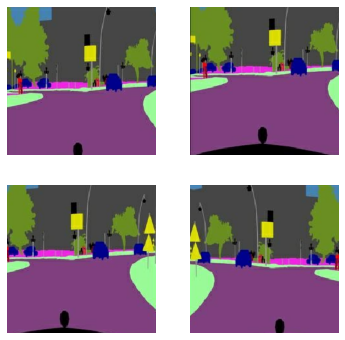

In [16]:
plt.figure(figsize=(6,6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2,2, i+1)
  plt.imshow(tf.cast(rj_re, tf.int16))
  plt.axis('off')
plt.show()

In [17]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image
  
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image 

In [18]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# U-Net Generator Implementation

---


What are Skip Connections?

*   Skip Connections (or Shortcut Connections) as the name suggests skips some of the layers in the neural network and feeds the output of one layer as the input to the next layers.Skip Connections were introduced to solve different problems in different architectures. In the case of ResNets, skip connections solved the [degradation problem](https://discovery.ucl.ac.uk/id/eprint/10061069/1/samplepaper.pdf) that we addressed earlier whereas, in the case of Densenets, it ensured feature reusability [Sivaram T — August 24, 2021](https://www.analyticsvidhya.com/blog/2021/08/all-you-need-to-know-about-skip-connections/#:~:text=awesome%20concept%20now.-,What%20are%20Skip%20Connections%3F,different%20problems%20in%20different%20architectures.)


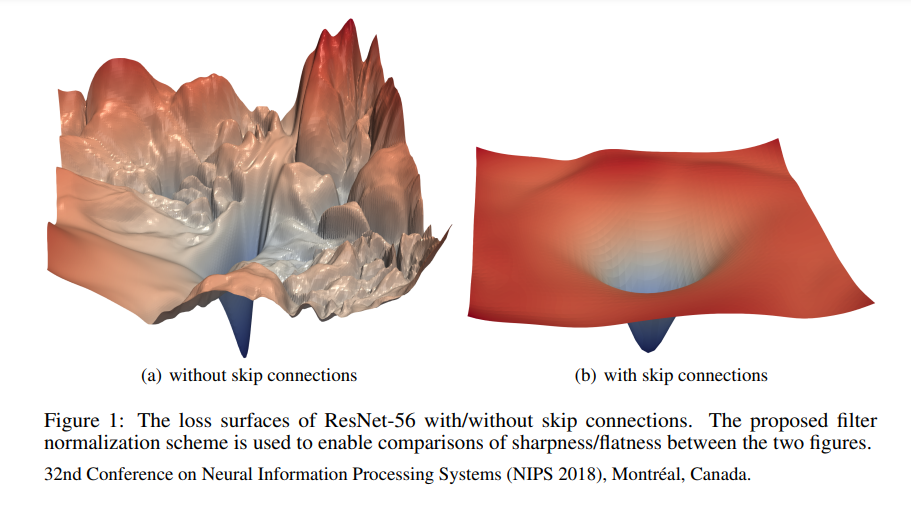










In [19]:
OUTPUT_CHANNELS = 3

In [20]:
# Encoder of U-Net 
def downsample(filters, size, apply_batchnorm=True):
  init = tf.random_uniform_initializer(minval=-0.02, maxval=0.02)
  res = tf.keras.Sequential()
  # note: use of regular 2D convolutions
  res.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=init, use_bias=False))
  if apply_batchnorm:
    res.add(tf.keras.layers.BatchNormalization())
  res.add(tf.keras.layers.LeakyReLU())
  return res

In [21]:
# Decoder of U-Net
def upsample(filters, size, apply_dropout=False):
  init = tf.random_uniform_initializer(minval=-0.02, maxval=0.02)
  res = tf.keras.Sequential()
  # note: use of transposed  2D convolutions
  res.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=init, use_bias=False))
  res.add(tf.keras.layers.BatchNormalization())
  if apply_dropout:
    res.add(tf.keras.layers.Dropout(0.5))
  res.add(tf.keras.layers.ReLU())
  return res

In [22]:
# Generator construction
def Generator():
#-----------------------------------------------Architecture Portion----------------------------------------------------#  
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  # encoder: (256, 256,3) -> (1,1,512)
  encoder_layers = [
    # note: batchnormilization is not applied to first layer
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  # decoder: (1,1, 512) -> (128, 128, 128)
  decoder_layers = [
    # note: dropout is applied to initial three layers (probably for depth reasons)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 512)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 512)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 512)
    upsample(512, 4),  # (batch_size, 16, 16, 512)
    upsample(256, 4),  # (batch_size, 32, 32, 256)
    upsample(128, 4),  # (batch_size, 64, 64, 128)
    upsample(64, 4),  # (batch_size, 128, 128, 64)           
  ]  
  init = tf.random_uniform_initializer(minval=-0.02, maxval=0.02)
  # decoder last layer: (128, 128, 64) -> (256, 256, 3)
  last = tf.keras.layers.Conv2DTranspose(filters=OUTPUT_CHANNELS, kernel_size=4, strides=2, padding='same', kernel_initializer=init, activation='tanh') # (batch_size, 256, 256, 3)  

#---------------------------------------------------Data Flow Portion----------------------------------------------------#
  x = inputs
  
  # Encoder 
  skips = []
  for enc in encoder_layers:
    x = enc(x)
    skips.append(x)

  # (1): skip list is reversed to feed decoder with most recent output for shape purpose 
  # i.e. [(2, 2, 512),(4, 4, 512),(8, 8, 512), (16, 16, 512),(32, 32, 256),(64, 64, 128), (128, 128, 64)]   
  skips = reversed(skips[:-1])

  # Decoder
  for dec, skip in zip(decoder_layers, skips):
    x = dec(x)
    # (2): skip list is implemented through concatenation
    #      X           skip 
    # [(2, 2, 512),(2, 2, 512)] -> (2,2,1024)
    # [(4, 4, 512), (4, 4, 512)] -> (4, 4, 1024)
    # [(8, 8, 512), (8, 8, 512)] -> (8, 8, 1024)
    #  etc...
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

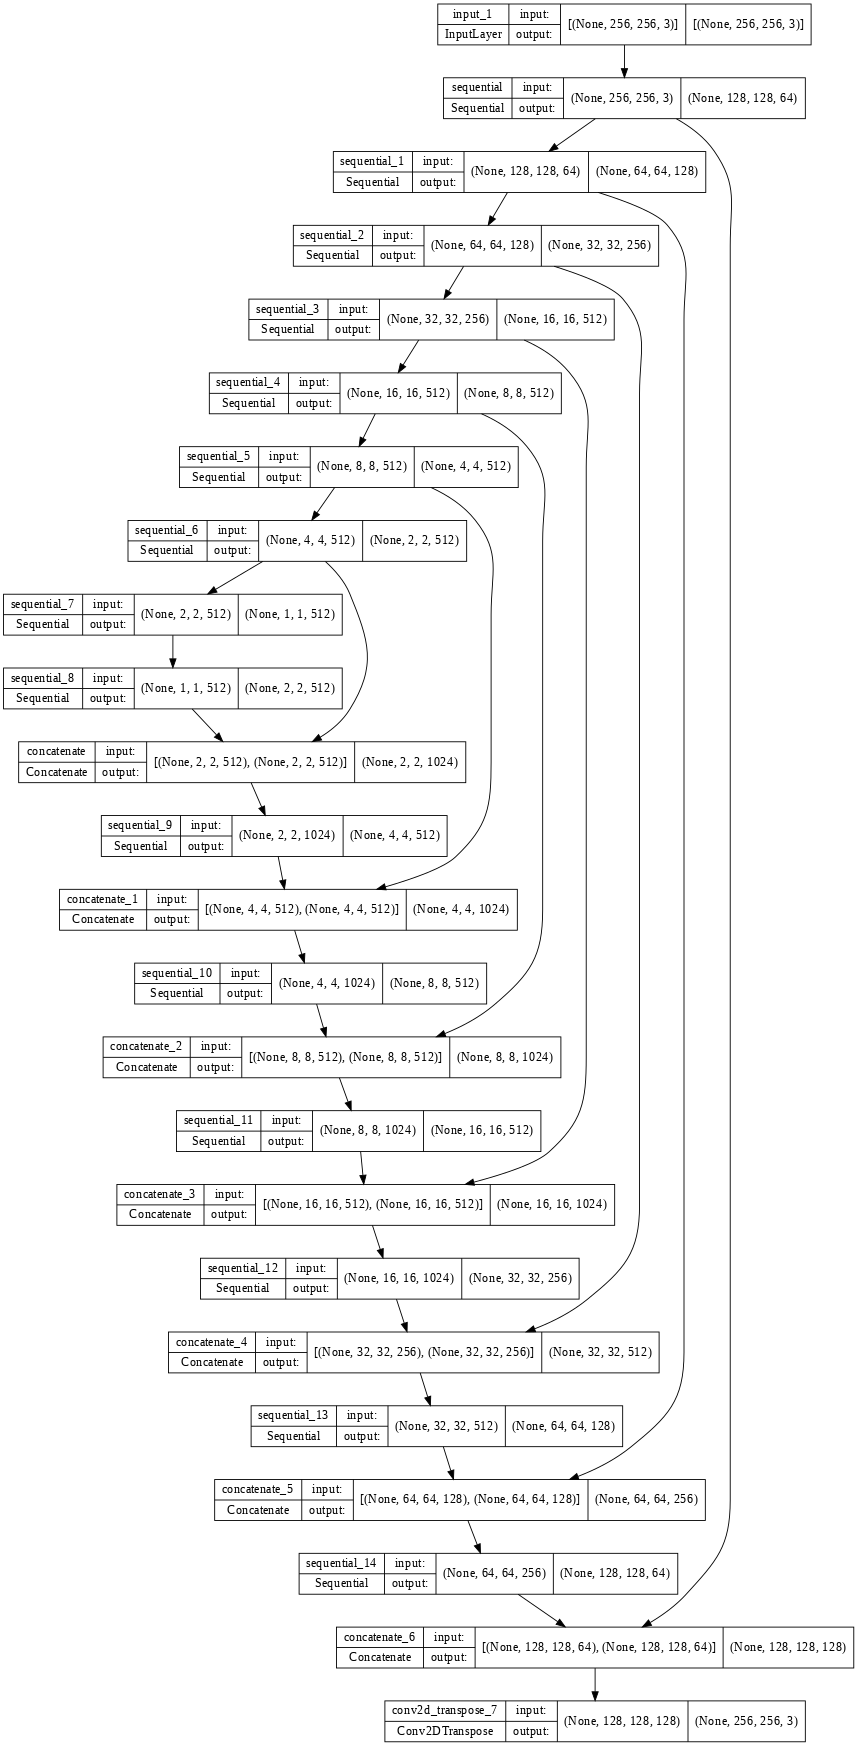

In [23]:
# U-Net Architecture illustrating encoder-decoder with skip connections
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


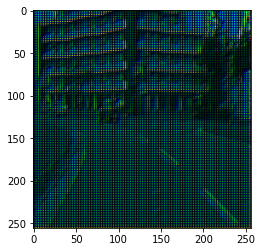

In [24]:
gen_output = generator(inp[tf.newaxis,:], training=False)
plt.imshow(gen_output[0, :])

# Generator loss


*   g_loss(1,x|z,y) = gan_loss(1,x|z) + LAMBDA*l1_loss(y, x|z)


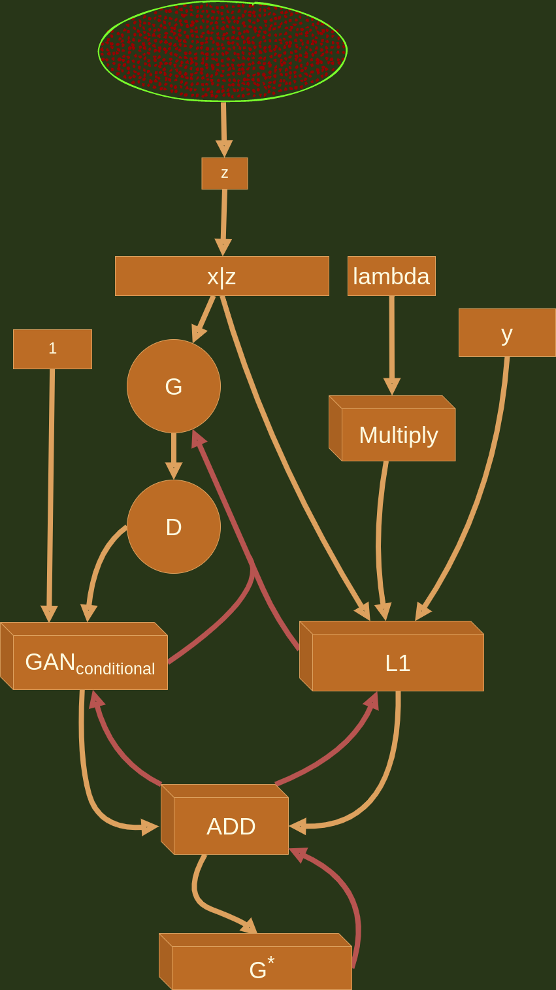



In [25]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def g_loss(d, g, y):
  gan_loss = loss_object(tf.ones_like(d), d)
  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(y-g))
  output = gan_loss + (LAMBDA*l1_loss)
  return output, gan_loss, l1_loss

# Discriminator

In [26]:
##Start Here